In [142]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from shapely.ops import split
from matplotlib.dates import DateFormatter
from shapely.geometry import LineString, Point

GLACIERS = ["DJ", "UI"]

terminus_boxes = gpd.read_file("../data/terminus/terminus_boxes.geojson")
terminus_positions = gpd.read_file("../data/terminus/terminus_traces_1978_2023.geojson")

out = []

for glacier in GLACIERS:
    print(f"Working on {glacier}")

    box = terminus_boxes[terminus_boxes["glacier_code"] == glacier].reset_index()
    traces = terminus_positions[terminus_positions["glacier_code"] == glacier]

    traces = traces.sort_values(by=["date"], ascending=False)

    for index, trace in traces.iterrows():
        difference = split(box.geometry[0], trace.geometry.geoms[0])

        start_relocate_distance = None
        end_relocate_distance = None

        if len(difference.geoms) == 1:
            trace_line = trace.geometry.geoms[0]
            trace_start = trace_line.coords[0]
            trace_end = trace_line.coords[-1]

            # # INITIAL STATE PLOT
            # fig, ax = plt.subplots()
            # x, y = box.geometry[0].geoms[0].exterior.xy
            # plt.plot(x, y, color="blue", alpha=0.5)
            # x, y = trace.geometry.geoms[0].xy
            # plt.plot(x, y, color="orange", alpha=0.5)
            # x, y = trace_start
            # plt.plot(x, y, color="green", marker="o", alpha=0.5)
            # x, y = trace_end
            # plt.plot(x, y, color="red", marker="o", alpha=0.5)
            # plt.title(f"initial: {index}; {trace.date}")
            # plt.show()

            nearest_start = (
                box.geometry[0]
                .geoms[0]
                .exterior.interpolate(
                    box.geometry[0].geoms[0].exterior.project(Point(trace_start))
                )
            )
            nearest_end = (
                box.geometry[0]
                .geoms[0]
                .exterior.interpolate(
                    box.geometry[0].geoms[0].exterior.project(Point(trace_end))
                )
            )

            if box.geometry[0].geoms[0].contains(Point(trace_start)):
                start_relocate_distance = nearest_start.distance(Point(trace_start))
                start_edge = (
                    box.geometry[0]
                    .geoms[0]
                    .exterior.interpolate(
                        box.geometry[0].geoms[0].exterior.project(nearest_start) - 50
                    )
                )
                start_vec = np.array(nearest_start.coords[0]) - np.array(start_edge.coords[0])
                start_perpendicular = (start_vec[1], -start_vec[0]) / np.linalg.norm(start_vec)
                trace_start_moved = (
                    nearest_start.x - start_perpendicular[0] * 50,
                    nearest_start.y - start_perpendicular[1] * 50,
                )
            else:
                trace_start_moved = trace_start

            if box.geometry[0].geoms[0].contains(Point(trace_end)):
                end_relocate_distance = nearest_end.distance(Point(trace_end))
                end_edge = (
                    box.geometry[0]
                    .geoms[0]
                    .exterior.interpolate(
                        box.geometry[0].geoms[0].exterior.project(nearest_end) + 50
                    )
                )
                end_vec = np.array(nearest_end.coords[0]) - np.array(end_edge.coords[0])
                end_perpendicular = (end_vec[1], -end_vec[0]) / np.linalg.norm(end_vec)
                trace_end_moved = (
                    nearest_end.x + end_perpendicular[0] * 50,
                    nearest_end.y + end_perpendicular[1] * 50,
                )
            else:
                trace_end_moved = trace_end

            trace_line_extended = list(trace_line.coords)
            trace_line_extended[0] = trace_start_moved
            trace_line_extended[-1] = trace_end_moved
            trace_line_extended = LineString(trace_line_extended)

            # # EXTENDED LINE PLOT
            # fig, ax = plt.subplots()
            # x, y = box.geometry[0].geoms[0].exterior.xy
            # plt.plot(x, y, color="blue", alpha=0.5)
            # x, y = trace_line_extended.xy
            # plt.plot(x, y, color="green", alpha=0.5)
            # plt.title(f"extended: {index}; {trace.date}")
            # plt.show()

            difference = split(box.geometry[0], trace_line_extended)

            # # CLOSED BOX PLOT
            # fig, ax = plt.subplots()
            # x, y = difference.geoms[1].exterior.xy
            # plt.plot(x, y, color="blue", alpha=0.5)
            # plt.title(f"difference: {index}; {trace.date}")
            # plt.show()

        difference_gdf = trace.drop(labels=["geometry"])
        difference_gdf["geometry"] = difference.geoms[1]
        difference_gdf["area"] = difference.geoms[1].area
        difference_gdf["area_width_averaged"] = difference.geoms[1].area / box.width[0]
        difference_gdf["start_relocated"] = start_relocate_distance
        difference_gdf["end_relocated"] = end_relocate_distance
        difference_gdf = gpd.GeoDataFrame(difference_gdf).transpose().set_geometry("geometry")
        difference_gdf.set_crs(terminus_positions.crs, inplace=True)

        out.append(difference_gdf)

out_gdf = pd.concat(out, ignore_index=True)
out_gdf = out_gdf.sort_values(by=["glacier_code", "date"])
out_gdf["area_width_averaged_change"] = out_gdf["area_width_averaged"] - out_gdf.groupby(
    ["glacier_code"]
)["area_width_averaged"].transform("first")
out_gdf.to_file("../data/terminus/terminus_boxes_1978_2023.geojson", driver="GeoJSON")

Working on DJ
Working on UI


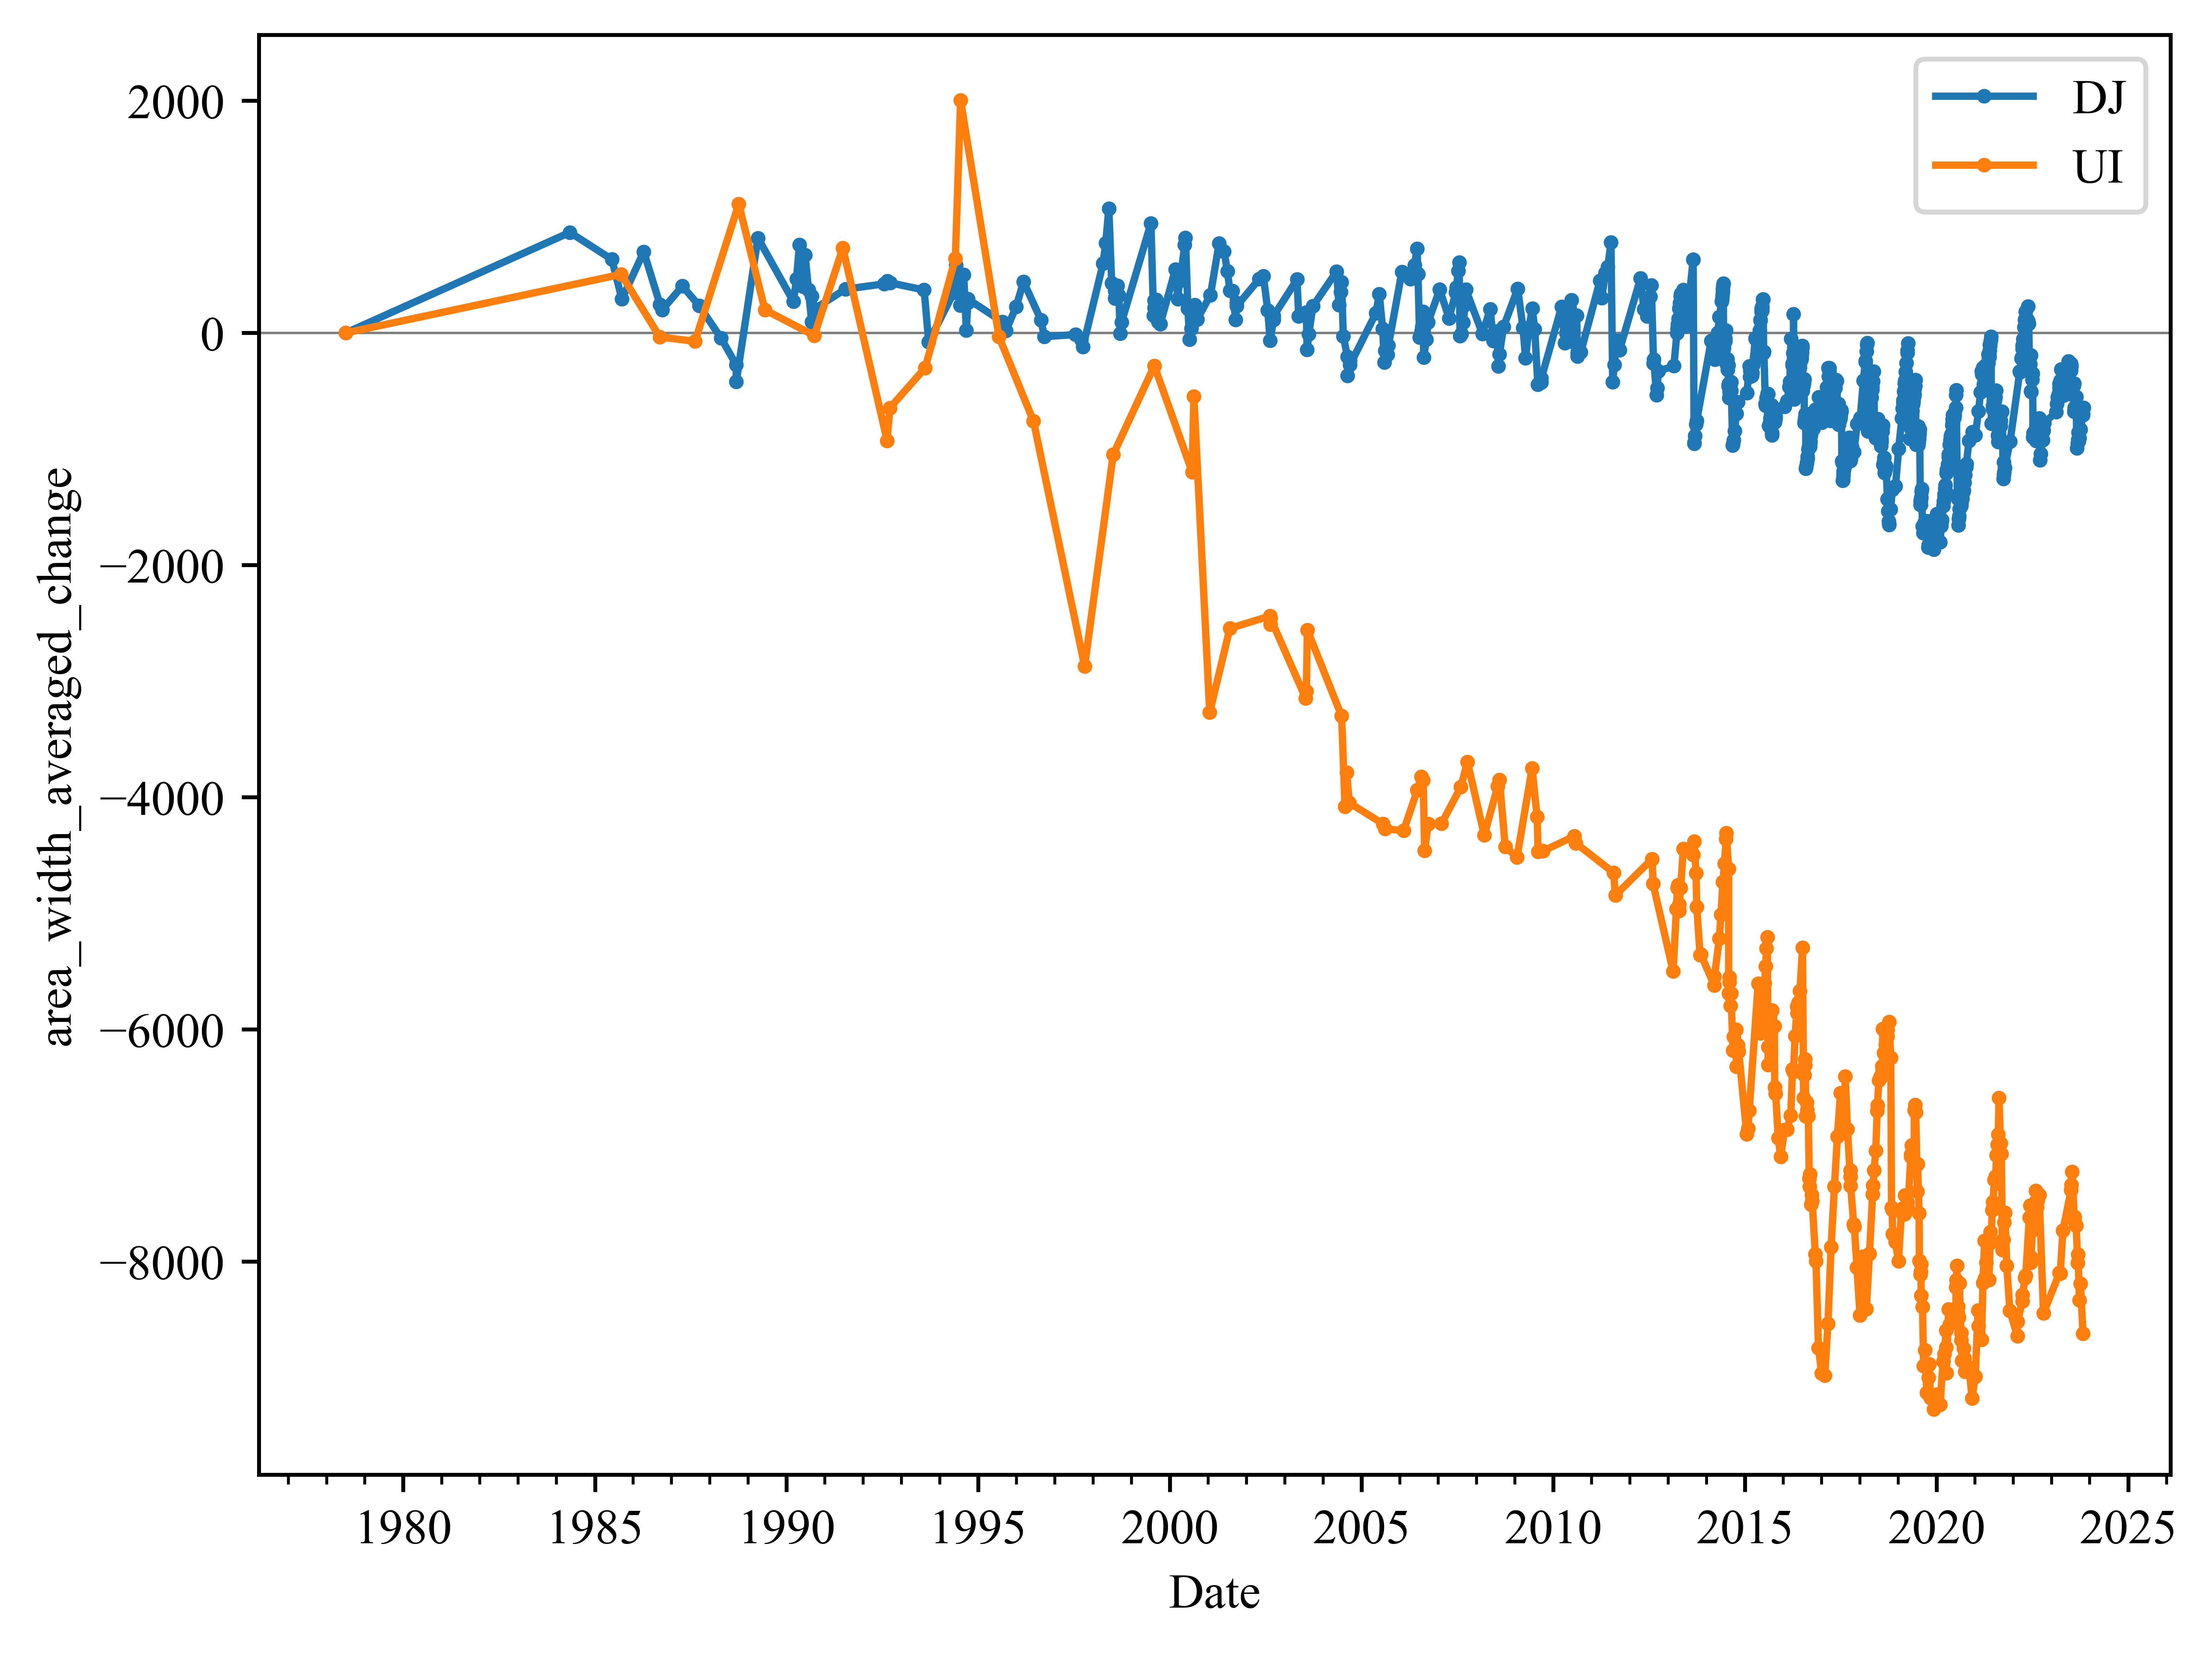

C:\Users\olive\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\olive\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\olive\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\olive\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future versi

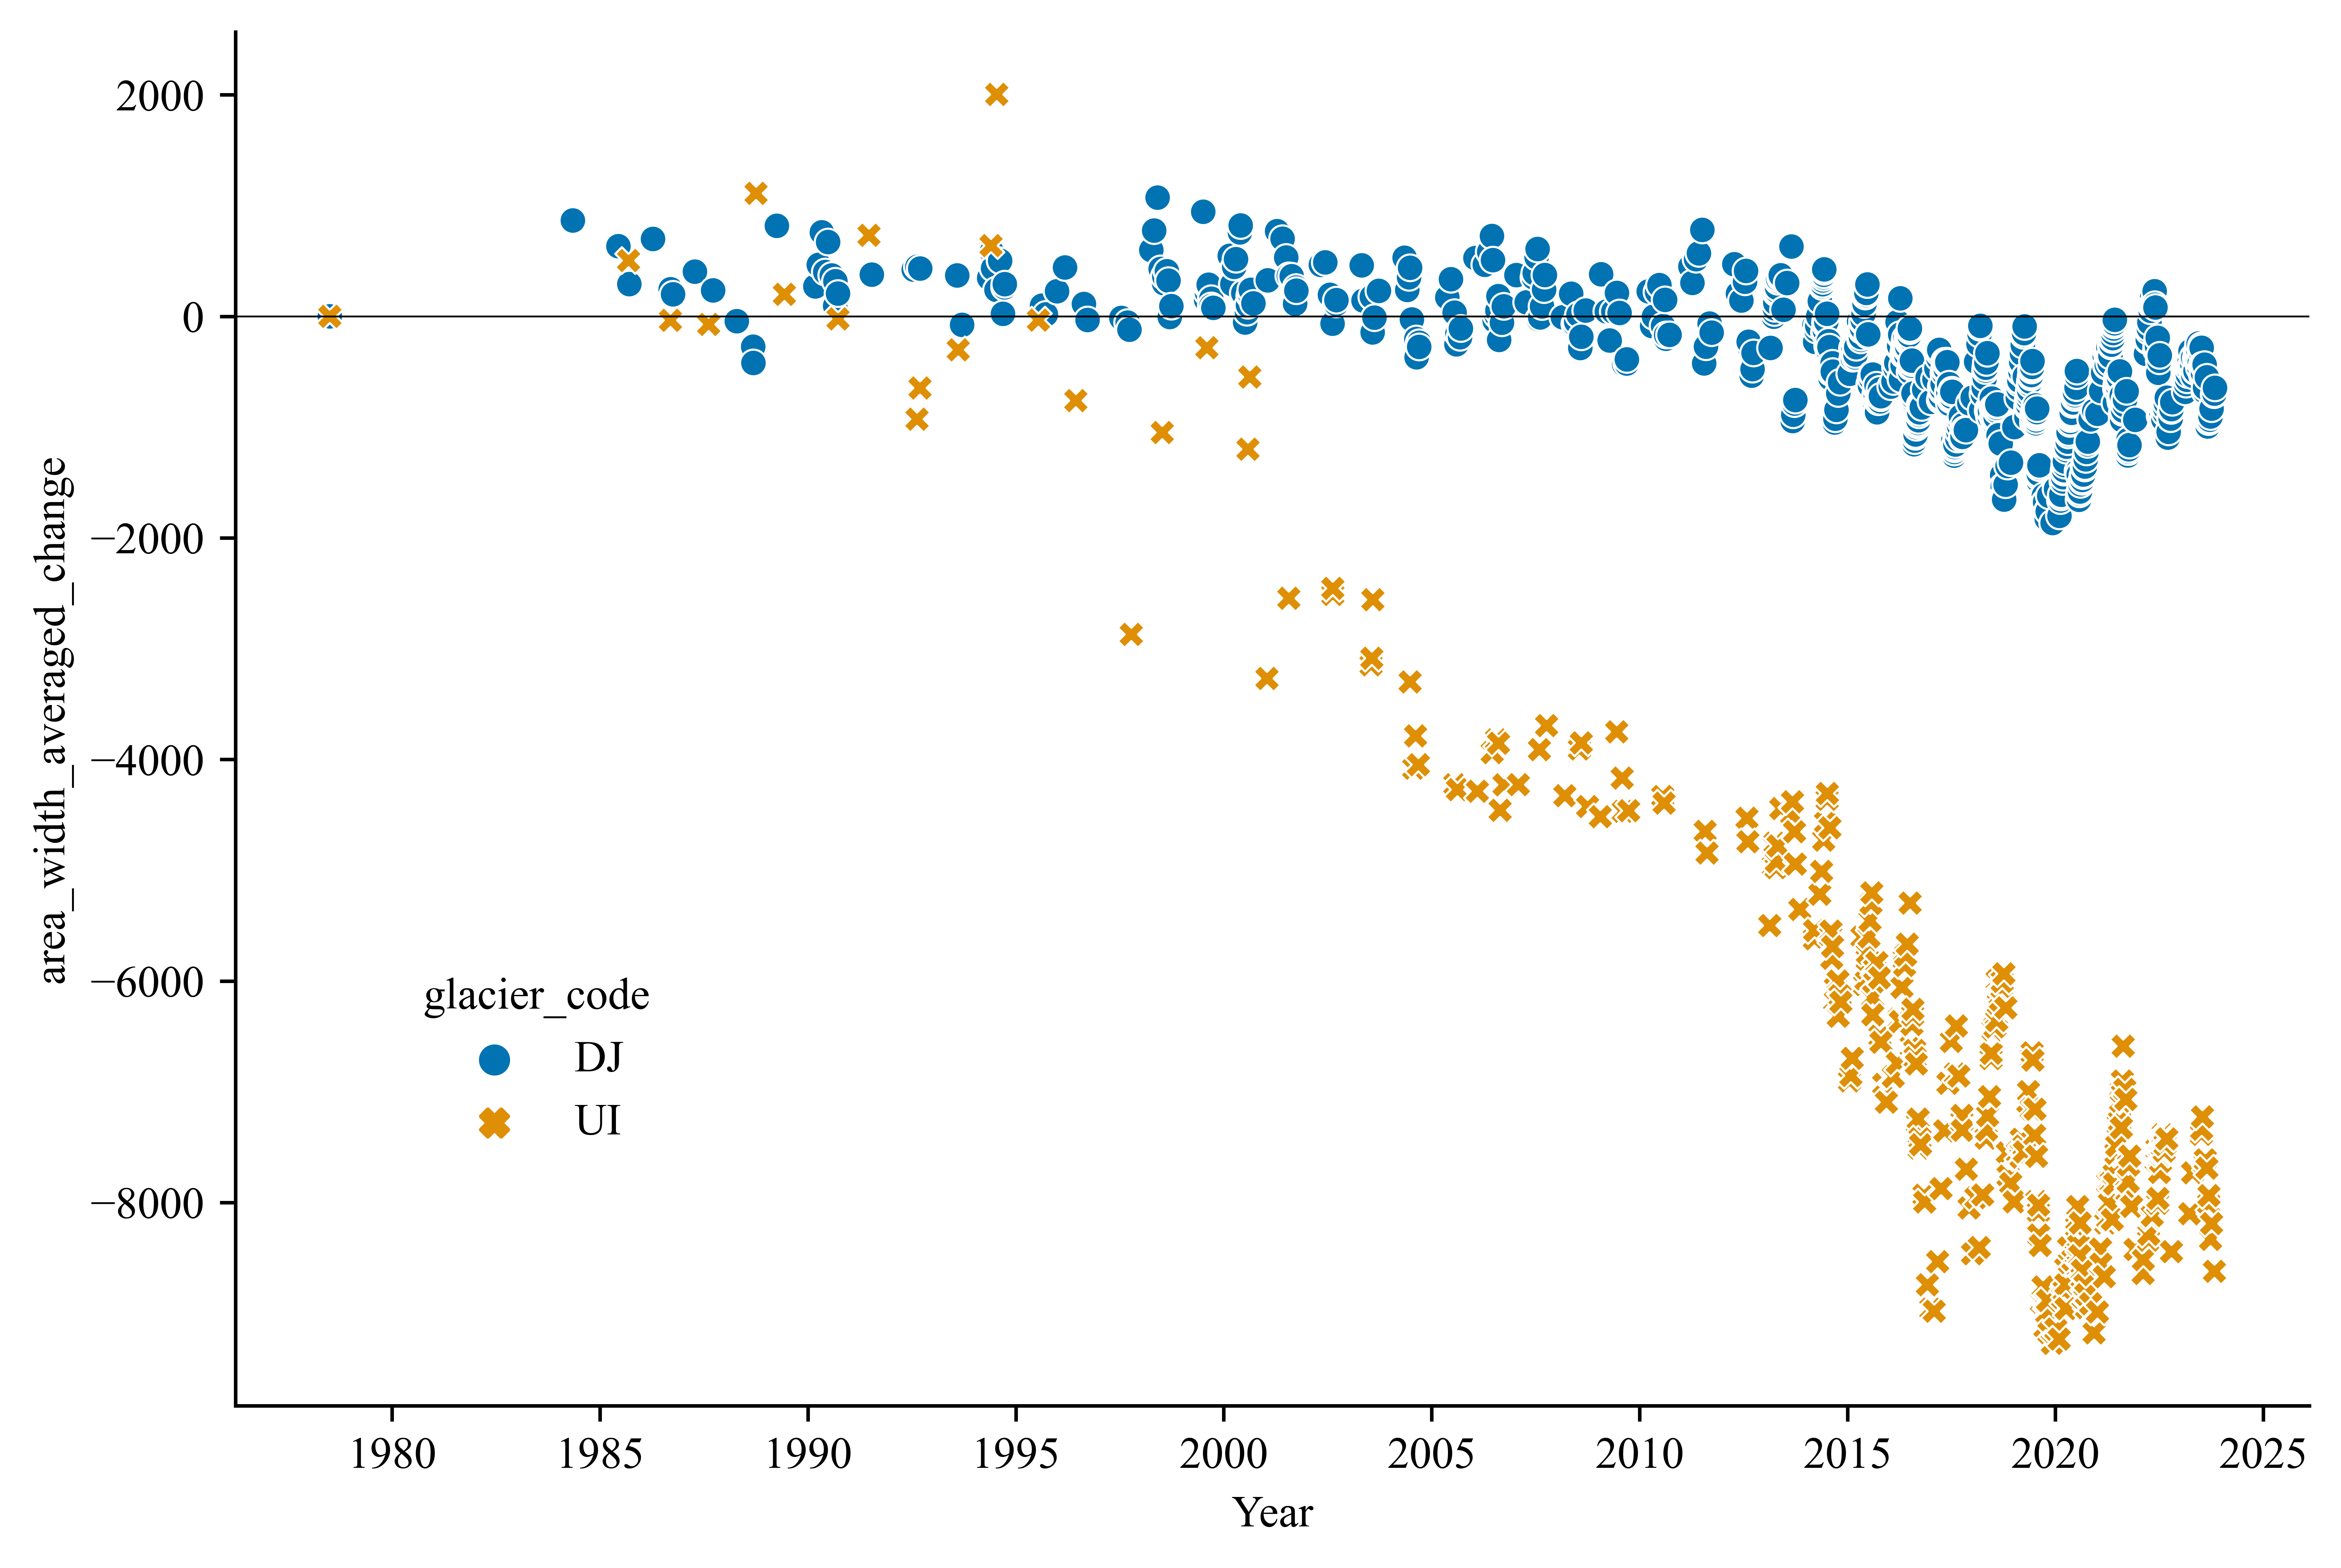

In [136]:
# PLOTTING

# Defines plot settings
plt.rcParams["axes.labelsize"] = 10
plt.rcParams["figure.dpi"] = 1000
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 10
plt.rcParams["mathtext.fontset"] = "stix"
plt.rcParams["xtick.labelsize"] = 10
plt.rcParams["ytick.labelsize"] = 10

# out_gdf = out_gdf[out_gdf["date"] > "2010-01-01"]
out_gdf["date"] = pd.to_datetime(out_gdf["date"])

for glacier in GLACIERS:
    glacier_data = out_gdf[out_gdf["glacier_code"] == glacier]
    plt.plot(
        glacier_data["date"],
        glacier_data["area_width_averaged_change"],
        label=glacier,
        marker="o",
        markersize=2,
    )

plt.xlabel("Date")
plt.ylabel("area_width_averaged_change")
plt.legend()
plt.axhline(y=0, c="black", alpha=0.5, linewidth=0.5, zorder=0)
plt.gca().xaxis.set_major_formatter(DateFormatter("%Y"))
# plt.xticks(rotation=45)
plt.tight_layout()
plt.gca().xaxis.set_minor_locator(plt.matplotlib.dates.YearLocator(1))

# plt.xlim(pd.Timestamp("2010-01-01"), pd.Timestamp("2022-01-01"))

plt.show()

import seaborn as sns

fig = sns.relplot(
    data=out_gdf,
    x="date",
    y="area_width_averaged_change",
    hue="glacier_code",
    palette="colorblind",
    hue_order=GLACIERS,
    style="glacier_code",
    style_order=GLACIERS,
    aspect=1.5,
    kind="scatter",
)
fig.map(plt.axhline, y=0, c="k", linewidth=0.4)
fig.set(
    ylabel=("area_width_averaged_change"),
    xlabel=("Year"),
    # ylim=(-410, 105),
    # xlim=(pd.Timestamp("2010-01-01"), pd.Timestamp("2022-01-01")),
)
sns.move_legend(fig, loc="lower left", bbox_to_anchor=(0.15, 0.25))
# fig.despine(trim=True)
date_fmt = DateFormatter("%Y")
fig.axes[0][0].xaxis.set_major_formatter(date_fmt)